In [1]:
pip install -q graphlearning

     |████████████████████████████████| 49 kB 2.4 MB/s 
     |████████████████████████████████| 646 kB 8.0 MB/s 
     |████████████████████████████████| 93 kB 1.3 MB/s 


In [2]:
## Import useful packages
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.image import extract_patches_2d
from scipy.ndimage import gaussian_filter
import graphlearning as gl
from scipy import sparse, linalg
from sklearn.cluster import KMeans
from scipy.special import softmax
from sklearn.decomposition import PCA as sklearn_pca
import urllib.request
import scipy.io

In [3]:
## Function to generate the weight matrix
def weight_matrix(data):
  boolean = False
  k=1
  I,J,D = gl.knnsearch_annoy(data, 50, similarity='angular')
  D[D==0] = 1e-150

  while boolean==False:
    k+=1
    W = gl.weight_matrix(I,J,D,k)
    boolean = gl.isconnected(W)
    print("k=%d"%k, "connected=%s"%boolean)

  k=2*k
  W = gl.weight_matrix(I,J,D,k)
  print("k=%d"%k, "connected=%s"%boolean)
  print("weight matrix shape: ", W.shape)
  
  return W

In [4]:
#Function to plot segmentation by laplace and poisson learning
def plot_image_segmentation(train_ind, labels, laplace_labels, poisson_labels, image_shape):
    laplace_seg = np.reshape(laplace_labels,image_shape[:2])
    poisson_seg = np.reshape(poisson_labels,image_shape[:2])
    gt = np.reshape(labels,image_shape[:2])

    # Create blank array of zeros same size as original image
    overlay_array = np.zeros((image_shape[0], image_shape[1]), dtype = int)

    # For loop that makes overlay array entries 1 where a label is taken from
    for i in range(len(train_ind)):
        y_loc = train_ind[i] // image_shape[1]
        x_loc = train_ind[i] % image_shape[0]

        overlay_array[y_loc, x_loc] = 1

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,4))
    ax1.set_title('Laplace Segmentation')
    ax1.imshow(laplace_seg)
    ax2.set_title('Poisson Segmentation')
    ax2.imshow(poisson_seg)
    ax3.set_title('Labeled Points')
    ax3.imshow(gt)
    ax3.imshow(overlay_array, alpha=0.7, cmap='gray')
    plt.show()

#Image preprocessing methods

In [5]:
## Function for Non-Local Means Method
def non_local_means(image, d):
  
  ## Pad the image with mirror reflections of itself with a width d
  pad = (d,d)
  padimage = np.pad(image,(pad,pad,(0,0)),mode='reflect') #(top,bottom),(left,right),(0,0)

  ## For the ith pixel, make a (2d + 1) by (2d + 1) patch centered at pixel i
  patches = extract_patches_2d(padimage, (2*d+1,2*d+1))

  ## For the jth, (j = 1; 2; 3) band, apply a Gaussian kernel on this patch
  u = np.zeros((2*d+1,2*d+1))
  u[d,d] = 1
  G = gaussian_filter(u,d/2,mode='constant',cval=0)
  patches = patches * G[np.newaxis,:,:,np.newaxis]

  ## Form the feature matrix F by letting each row of F be a feature vector of a pixel
  F = patches.reshape((patches.shape[0],patches.shape[1]*patches.shape[2]*patches.shape[3]))
  print("feature vector shape: ", F.shape)

  return F

In [6]:
#Function to perform PCA on image
def PCA(image, component=False):

  #Perform PCA with 60 components
  pca = sklearn_pca(n_components=60)
  X = image.reshape(image.shape[0]*image.shape[1],image.shape[2])
  pca.fit(X)
  variance = 100*(pca.explained_variance_ratio_)

  #Get the number of components with variance greater than 0.005%
  num_components = len(variance[variance>5e-3])

  #Perform PCA with the new number of components
  pca = sklearn_pca(n_components=num_components)
  pca_image = pca.fit_transform(X)
  print("Total Variation (%d components): "%num_components, np.sum(pca.explained_variance_ratio_))
  pca_image = pca_image.reshape(image.shape[0], image.shape[1], num_components)
  print("pca image shape: ", pca_image.shape)
  
  if component==True:
    return pca_image, num_components
  return pca_image

# Active learning Methods

In [34]:
import graphlearning as gl
import numpy as np
from scipy import sparse, linalg
from scipy.special import softmax
import matplotlib
import matplotlib.pyplot as plt

In [35]:
#Function to randomly select points from each class and perform laplace and poisson learning
def initial_run(W, labels, num_train_per_class, algorithm, random_state, plot=False):
  #Initialize training points
  num_pts = W.shape[0]
  num_classes = len(np.unique(labels))
  np.random.seed(random_state)
  train_ind = gl.randomize_labels(labels,num_train_per_class)
  np.random.seed()
  print("%f%% training data"%(100*len(train_ind)/num_pts))

  #GSSL
  u = gl.graph_ssl(W, train_ind, labels[train_ind], algorithm=algorithm, return_vector=True)
  pred_labels = np.argmax(u, axis=1)
  pred_acc = gl.accuracy(labels, pred_labels, len(train_ind))

  #Output results
  if plot is True: 
    scatterplot(data, labels, train_ind, [], pred_labels, algorithm) 
  print('Number of Labels,Accuracy')
  print('%s: %d,%.3f'%(algorithm,len(train_ind),pred_acc))

  return train_ind, pred_acc, u

In [36]:
#Function to perform simulation using random sampling
def random_simulation(W, labels, num_train_per_class, num_labels, algorithm, method, random_state=0, plot=False):
  print("Random Sampling")
  num_pts = W.shape[0]
  num_classes = len(np.unique(labels))
  train_ind, pred_acc, u = initial_run(W, labels, num_train_per_class, algorithm, random_state, plot=plot)

  #Create arrays to store results
  num_train = np.array([len(train_ind)])
  gssl = np.array([pred_acc])

  #loop for adding new labeled datapoints
  while len(train_ind) < num_labels:
    obj_values = np.ones(num_pts)
    obj_values[train_ind] = 0
    obj_values = obj_values/np.sum(obj_values)
    if method is 'batch':
      for label in np.unique(labels):
        label_indices = np.array(np.where(np.argmax(u,axis=1)==label))[0]
        values_per_class = obj_values[label_indices]/np.sum(obj_values[label_indices])
        new_train_ind = np.random.choice(label_indices, size=1, replace=False, p=values_per_class)
        train_ind = np.append(train_ind,new_train_ind)
    elif method is 'sequential':
      new_train_ind = np.random.choice(num_pts, size=1, replace=False, p=obj_values)
      train_ind = np.append(train_ind,new_train_ind)
    
    #GSSL
    u = gl.graph_ssl(W, train_ind, labels[train_ind], algorithm=algorithm, return_vector=True)
    pred_labels = np.argmax(u, axis=1)
    pred_acc = gl.accuracy(labels, pred_labels, len(train_ind))

    #Output results
    if plot is True: 
      scatterplot(data, labels, train_ind, obj_values, pred_labels, algorithm) 
    print(obj_values.min(), obj_values.max())
    print('Number of Labels,Accuracy')
    print('%s: %d,%.3f'%(algorithm,len(train_ind),pred_acc))

    #Update arrays
    num_train = np.append(num_train, len(train_ind))
    gssl = np.append(gssl, pred_acc)
  print()

  return num_train, gssl

In [37]:
def stats(uncertainty_values, filename):
  mean = np.mean(uncertainty_values)
  std = np.std(uncertainty_values)
  quantile1 = np.quantile(uncertainty_values, 0.25)
  median = np.quantile(uncertainty_values, 0.5)
  quantile3 = np.quantile(uncertainty_values, 0.75)
  min = np.min(uncertainty_values)
  max = np.max(uncertainty_values)
  with open('%s.csv'%filename, 'a') as f:
    f.writelines(f"mean=%.3f, std=%.3f, quantiles=(%.3f, %.3f, %.3f, %.3f, %.3f)"%(mean,std,min,quantile1,median,quantile3,max)+'\n')

#VOPT paper uncertainty sampling
# def uncertainty(u, labeled_ind=None):
#   #u is num_pts x num_classes
#   num_pts = u.shape[0]
#   sorted = np.sort(u, axis=1)
#   obj_values = 1-(sorted[:,-1]-sorted[:,-2])
#   if labeled_ind is None:
#     return obj_values
#   else:
#     obj_values[labeled_ind] = obj_values.min()
#     return obj_values

#Kevin's uncertainty sampling
def uncertainty(u, labeled_ind=None):
    num_pts = u.shape[0]
    num_classes = u.shape[1]
    u_probs = softmax(u, axis=1) 
    one_hot_predicted_labels = np.eye(num_classes)[np.argmax(u, axis=1)]
    obj_values = np.linalg.norm((u_probs - one_hot_predicted_labels), axis=1)
    if labeled_ind is None:
        return obj_values
    else:
        obj_values[labeled_ind] = obj_values.min()
    return obj_values

#Function to perform simulation using uncertainty sampling
def uncertainty_simulation(W, labels, num_train_per_class, num_labels, algorithm, method, random_state=0, plot=False):
  print("Uncertainty Sampling")
  num_pts = W.shape[0]
  num_classes = len(np.unique(labels))
  train_ind, pred_acc, u = initial_run(W, labels, num_train_per_class, algorithm, random_state, plot=plot)

  #Create arrays to store results
  num_train = np.array([len(train_ind)])
  gssl = np.array([pred_acc])

  #loop for adding new labeled datapoints
  while len(train_ind) < num_labels:
    obj_values = uncertainty(u, train_ind)
    stats(obj_values, 'uncertainty_sampling')
    if method is 'batch':
      for label in np.unique(labels):
        label_indices = np.array(np.where(np.argmax(u,axis=1)==label))[0]
        new_train_ind = label_indices[np.argmax(obj_values[label_indices])]
        train_ind = np.append(train_ind,new_train_ind)
    elif method is 'sequential':
      new_train_ind = np.argmax(obj_values)
      train_ind = np.append(train_ind,new_train_ind)
    
    #GSSL
    u = gl.graph_ssl(W, train_ind, labels[train_ind], algorithm=algorithm, return_vector=True)
    pred_labels = np.argmax(u, axis=1)
    pred_acc = gl.accuracy(labels, pred_labels, len(train_ind))

    #Output results
    if plot is True: 
      scatterplot(data, labels, train_ind, obj_values, pred_labels, algorithm)
    print(obj_values.min(), obj_values.max()) 
    print('Number of Labels,Accuracy')
    print('%s: %d,%.3f'%(algorithm,len(train_ind),pred_acc))

    #Update arrays
    num_train = np.append(num_train, len(train_ind))
    gssl = np.append(gssl, pred_acc)
  print()

  return num_train, gssl

In [38]:
#Function to initialize covariance matrix
def init_c(evals, evecs, labeled_ind=None):
    # do not include evals that are very close to 0!
    K = (evecs/evals[np.newaxis, :]) @ evecs.T
    if labeled_ind is None:
      return K
    else:  
      unlabeled_ind = list(filter(lambda x: x not in labeled_ind, range(evecs.shape[0])))
      C = K[np.ix_(unlabeled_ind, unlabeled_ind)] - K[np.ix_(unlabeled_ind, labeled_ind)] @ linalg.inv(K[np.ix_(labeled_ind, labeled_ind)]) \
                                                              @ K[np.ix_(labeled_ind, unlabeled_ind)]
      print("negative diagonals:",np.sum(np.diag(C)<=0))
      print("negative entries:",np.sum(C<0))
      return C

#Function to update the covariance matrix
def update_c(C, max_idx, labeled_ind):
    unlabeled_ind = np.delete(np.arange(C.shape[0]+len(labeled_ind)), labeled_ind)
    k = np.where(unlabeled_ind == max_idx)[0][0]
    C -= np.outer(C[:,k], C[:,k])/C[k,k]
    not_k = np.delete(np.arange(C.shape[0]), k)
    C = C[np.ix_(not_k, not_k)]
    print("negative diagonals:",np.sum(np.diag(C)<=0))
    print("negative entries:",np.sum(C<0))
    return C

#Function to calculate v-opt objective function values
def v_opt(C, labeled_ind=None):
  unl_values = np.array([np.linalg.norm(C[i])**2/C[i,i] for i in range(C.shape[0])])
  if labeled_ind is None:
    return unl_values
  else:
    num_pts = C.shape[0] + len(labeled_ind)
    obj_values = np.ones(num_pts)*unl_values.min() 
    unlabeled_ind = np.delete(np.arange(num_pts), labeled_ind)
    obj_values[unlabeled_ind] = unl_values
    return obj_values

#Function to perform simulation using uncertainty sampling
def vopt_simulation(W, labels, num_train_per_class, num_labels, algorithm, method, random_state=0, plot=False):
  print("V-Optimality")
  num_pts = W.shape[0]
  num_classes = len(np.unique(labels))
  train_ind, pred_acc, u = initial_run(W, labels, num_train_per_class, algorithm, random_state, plot=plot)

  #Create arrays to store results
  num_train = np.array([len(train_ind)])
  gssl = np.array([pred_acc])

  #Formulations
  L=gl.graph_laplacian(W) #construct the graph laplacian
  k=int(1.1*num_labels) #number of eigenvalues/vectors
  vals, X = sparse.linalg.eigs(L,k=k, which='SM')
  X = X.real  
  vals = vals.real
  vals[0] = 0
  C = init_c(vals+1e-4, X, train_ind) #initialize cov matrix

  #loop for adding new labeled datapoints
  while len(train_ind) < num_labels:
    obj_values = v_opt(C, train_ind)
    if method is 'batch':
      for label in np.unique(labels):
        label_indices = np.array(np.where(np.argmax(u,axis=1)==label))[0]
        new_train_ind = label_indices[np.argmax(obj_values[label_indices])]
        C = update_c(C, new_train_ind, train_ind) #update cov matrix
        train_ind = np.append(train_ind,new_train_ind)
    elif method is 'sequential':
      new_train_ind = np.argmax(obj_values)
      C = update_c(C, new_train_ind, train_ind) #update cov matrix
      train_ind = np.append(train_ind,new_train_ind)
    
    #GSSL
    u = gl.graph_ssl(W, train_ind, labels[train_ind], algorithm=algorithm, return_vector=True)
    pred_labels = np.argmax(u, axis=1)
    pred_acc = gl.accuracy(labels, pred_labels, len(train_ind))

    #Output results
    if plot is True: 
      scatterplot(data, labels, train_ind, obj_values, pred_labels, algorithm) 
    print(obj_values.min(), obj_values.max())
    print('Number of Labels,Accuracy')
    print('%s: %d,%.3f'%(algorithm,len(train_ind),pred_acc))

    #Update arrays
    num_train = np.append(num_train, len(train_ind))
    gssl = np.append(gssl, pred_acc)
  print()

  return num_train, gssl

In [39]:
#Function to calculate sigma-opt objective function values
def sigma_opt(C, labeled_ind=None):
  unl_values = np.array([np.sum(C[i])**2/C[i,i] for i in range(C.shape[0])])
  if labeled_ind is None:
    return unl_values
  else:
    num_pts = C.shape[0] + len(labeled_ind)
    obj_values = np.ones(num_pts)*unl_values.min() 
    unlabeled_ind = np.delete(np.arange(num_pts), labeled_ind)
    obj_values[unlabeled_ind] = unl_values
    return obj_values

#Function to perform simulation using sigma-opt
def sigmaopt_simulation(W, labels, num_train_per_class, num_labels, algorithm, method, random_state=0, plot=False):
  print("Sigma-Optimality")
  num_pts = W.shape[0]
  num_classes = len(np.unique(labels))
  train_ind, pred_acc, u = initial_run(W, labels, num_train_per_class, algorithm, random_state, plot=plot)

  #Create arrays to store results
  num_train = np.array([len(train_ind)])
  gssl = np.array([pred_acc])

  #Formulations
  L=gl.graph_laplacian(W) #construct the graph laplacian
  k=int(1.1*num_labels) #number of eigenvalues/vectors
  vals, X = sparse.linalg.eigs(L,k=k, which='SM')
  X = X.real  
  vals = vals.real
  vals[0] = 0
  C = init_c(vals+1e-4, X, train_ind) #initialize cov matrix

  #loop for adding new labeled datapoints
  while len(train_ind) < num_labels:
    obj_values = sigma_opt(C, train_ind)
    if method is 'batch':
      for label in np.unique(labels):
        label_indices = np.array(np.where(np.argmax(u,axis=1)==label))[0]
        new_train_ind = label_indices[np.argmax(obj_values[label_indices])]
        C = update_c(C, new_train_ind, train_ind) #update cov matrix
        train_ind = np.append(train_ind,new_train_ind)
    elif method is 'sequential':
      new_train_ind = np.argmax(obj_values)
      C = update_c(C, new_train_ind, train_ind) #update cov matrix
      train_ind = np.append(train_ind,new_train_ind)
    
    #GSSL
    u = gl.graph_ssl(W, train_ind, labels[train_ind], algorithm=algorithm, return_vector=True)
    pred_labels = np.argmax(u, axis=1)
    pred_acc = gl.accuracy(labels, pred_labels, len(train_ind))

    #Output results
    if plot is True: 
      scatterplot(data, labels, train_ind, obj_values, pred_labels, algorithm) 
    print(obj_values.min(), obj_values.max())
    print('Number of Labels,Accuracy')
    print('%s: %d,%.3f'%(algorithm,len(train_ind),pred_acc))

    #Update arrays
    num_train = np.append(num_train, len(train_ind))
    gssl = np.append(gssl, pred_acc)
  print()

  return num_train, gssl

In [40]:
#Function to calculate MC-VOpt objective function values
def mc_vopt(C, u, labeled_ind=[]):
  num_pts = C.shape[0] + len(labeled_ind)
  unlabeled_ind = np.delete(np.arange(num_pts), labeled_ind)
  uncertainty_terms = uncertainty(u)[unlabeled_ind]
  unl_values = np.array([np.linalg.norm(C[i])**2/C[i,i] for i in range(C.shape[0])])*uncertainty_terms
  if labeled_ind is []:
    return unl_values, uncertainty_terms
  else:
    obj_values = np.ones(num_pts)*unl_values.min() 
    obj_values[unlabeled_ind] = unl_values
    return obj_values, uncertainty_terms

#Function to perform simulation using sigma-opt
def mc_vopt_simulation(W, labels, num_train_per_class, num_labels, algorithm, method, random_state=0, plot=False):
  print("MC-VOptimality")
  num_pts = W.shape[0]
  num_classes = len(np.unique(labels))
  train_ind, pred_acc, u = initial_run(W, labels, num_train_per_class, algorithm, random_state, plot=plot)

  #Create arrays to store results
  num_train = np.array([len(train_ind)])
  gssl = np.array([pred_acc])

  #Formulations
  L=gl.graph_laplacian(W) #construct the graph laplacian
  k=int(1.1*num_labels) #number of eigenvalues/vectors
  vals, X = sparse.linalg.eigs(L,k=k, which='SM')
  X = X.real  
  vals = vals.real
  vals[0] = 0
  C = init_c(vals+1e-4, X, train_ind) #initialize cov matrix

  #loop for adding new labeled datapoints
  while len(train_ind) < num_labels:
    obj_values, unc_values = mc_vopt(C, u, train_ind)
    stats(unc_values, 'mc_vopt') 
    if method is 'batch':
      for label in np.unique(labels):
        label_indices = np.array(np.where(np.argmax(u,axis=1)==label))[0]
        new_train_ind = label_indices[np.argmax(obj_values[label_indices])]
        C = update_c(C, new_train_ind, train_ind) #update cov matrix
        train_ind = np.append(train_ind,new_train_ind)
    elif method is 'sequential':
      new_train_ind = np.argmax(obj_values)
      C = update_c(C, new_train_ind, train_ind) #update cov matrix
      train_ind = np.append(train_ind,new_train_ind)
    
    #GSSL
    u = gl.graph_ssl(W, train_ind, labels[train_ind], algorithm=algorithm, return_vector=True)
    pred_labels = np.argmax(u, axis=1)
    pred_acc = gl.accuracy(labels, pred_labels, len(train_ind))

    #Output results
    if plot is True: 
      scatterplot(data, labels, train_ind, obj_values, pred_labels, algorithm) 
    print(obj_values.min(), obj_values.max())
    print('Number of Labels,Accuracy')
    print('%s: %d,%.3f'%(algorithm,len(train_ind),pred_acc))

    #Update arrays
    num_train = np.append(num_train, len(train_ind))
    gssl = np.append(gssl, pred_acc)
  print()

  return num_train, gssl

In [41]:
#Function to calculate MC-VOpt objective function values
def model_change(C, u, labeled_ind=[]):
  num_pts = C.shape[0] + len(labeled_ind)
  unlabeled_ind = np.delete(np.arange(num_pts), labeled_ind)
  uncertainty_terms = uncertainty(u)[unlabeled_ind]
  unl_values = np.array([np.linalg.norm(C[i])/C[i,i] for i in range(C.shape[0])])*uncertainty_terms
  if labeled_ind is []:
    return unl_values, uncertainty_terms
  else:
    obj_values = np.ones(num_pts)*unl_values.min() 
    obj_values[unlabeled_ind] = unl_values
    return obj_values, uncertainty_terms

#Function to perform simulation using sigma-opt
def mc_simulation(W, labels, num_train_per_class, num_labels, algorithm, method, random_state=0, plot=False):
  print("Model Change")
  num_pts = W.shape[0]
  num_classes = len(np.unique(labels))
  train_ind, pred_acc, u = initial_run(W, labels, num_train_per_class, algorithm, random_state, plot=plot)

  #Create arrays to store results
  num_train = np.array([len(train_ind)])
  gssl = np.array([pred_acc])

  #Formulations
  L=gl.graph_laplacian(W) #construct the graph laplacian
  k=int(1.1*num_labels) #number of eigenvalues/vectors
  vals, X = sparse.linalg.eigs(L,k=k, which='SM')
  X = X.real  
  vals = vals.real
  vals[0] = 0
  C = init_c(vals+1e-4, X, train_ind) #initialize cov matrix

  #loop for adding new labeled datapoints
  while len(train_ind) < num_labels:
    obj_values, unc_values = model_change(C, u, train_ind)
    stats(unc_values, 'model_change') 
    if method is 'batch':
      for label in np.unique(labels):
        label_indices = np.array(np.where(np.argmax(u,axis=1)==label))[0]
        new_train_ind = label_indices[np.argmax(obj_values[label_indices])]
        C = update_c(C, new_train_ind, train_ind) #update cov matrix
        train_ind = np.append(train_ind,new_train_ind)
    elif method is 'sequential':
      new_train_ind = np.argmax(obj_values)
      C = update_c(C, new_train_ind, train_ind) #update cov matrix
      train_ind = np.append(train_ind,new_train_ind)
    
    #GSSL
    u = gl.graph_ssl(W, train_ind, labels[train_ind], algorithm=algorithm, return_vector=True)
    pred_labels = np.argmax(u, axis=1)
    pred_acc = gl.accuracy(labels, pred_labels, len(train_ind))

    #Output results
    if plot is True: 
      scatterplot(data, labels, train_ind, obj_values, pred_labels, algorithm) 
    print(obj_values.min(), obj_values.max())
    print('Number of Labels,Accuracy')
    print('%s: %d,%.3f'%(algorithm,len(train_ind),pred_acc))

    #Update arrays
    num_train = np.append(num_train, len(train_ind))
    gssl = np.append(gssl, pred_acc)
  print()

  return num_train, gssl

In [42]:
#Function to plot the laplace and poisson accuracy
def lineplot(num_train, random_acc, uncertainty_acc, vopt_acc, sopt_acc, mc_acc, mcvopt_acc, algorithm, filename=None):
  plt.figure(figsize=(12, 8), dpi=100)
  matplotlib.rcParams.update({'font.size': 16})
  plt.plot(num_train, random_acc, 'gx-', markersize=10, label='Random')
  plt.plot(num_train, uncertainty_acc, 'c+-', markersize=10, label='Uncertainty')
  plt.plot(num_train, vopt_acc, 'bv-', markersize=10, label='V-Opt')
  plt.plot(num_train, sopt_acc, 'rs-', markersize=10, label='Sigma-Opt')
  plt.plot(num_train, mc_acc, 'yo-', markersize=10, label='Model Change')
  plt.plot(num_train, mcvopt_acc, 'k*-', markersize=10, label='MC-VOpt')
  plt.xlabel('number of labeled points')
  plt.ylabel('%s Learning Accuracy'%algorithm)
  plt.legend()
  if filename is not None: plt.savefig('%s.png'%filename)
  plt.show()
  print("rand: %.3f"%random_acc.max(), "unc: %.3f"%uncertainty_acc.max(), "vopt: %.3f"%vopt_acc.max(), "sopt: %.3f"%sopt_acc.max(), "mc: %.3f"%mc_acc.max(), "mc-vopt: %.3f"%mcvopt_acc.max())

In [43]:
#Function to plot the selected points and the objective function values
def scatterplot(data, labels, train_ind, obj_values, pred_labels, algorithm):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,4))
    matplotlib.rcParams.update({'font.size': 12})
    
    ##FIRST PLOT
    #plot the labeled and unlabeled points
    ax1.set_title('Active Learning Selection')
    ax1.scatter(data[:, 0], data[:, 1], c=labels, s=25, alpha=0.3)
    ax1.scatter(data[train_ind, 0], data[train_ind, 1], c='r')

    ##SECOND PLOT
    #plot the objective function values
    #lowest = darkest (dark blue)
    #highest = brightest (yellow)
    ax2.set_title("Objective Values")
    ax2.scatter(data[:, 0], data[:, 1], c=obj_values, alpha=0.5)
##    plt.savefig(str(len(train_ind))+' labels.png')

    ##THIRD PLOT
    ax3.set_title("%s Classification"%algorithm)
    ax3.scatter(data[:, 0], data[:, 1], c=pred_labels, s=25, alpha=0.3)
    plt.show()

In [44]:
def active_learning_simulation(W, labels, num_train_per_class, num_labels, algorithm, method, random_state=0, plot=False):
  num_train, rand = random_simulation(W, labels, num_train_per_class, num_labels, algorithm, method, random_state, plot)
  _, unc = uncertainty_simulation(W, labels, num_train_per_class, num_labels, algorithm, method, random_state, plot)
  _, vopt = vopt_simulation(W, labels, num_train_per_class, num_labels, algorithm, method, random_state, plot)
  _, sopt = sigmaopt_simulation(W, labels, num_train_per_class, num_labels, algorithm, method, random_state, plot)
  _, mc = mc_simulation(W, labels, num_train_per_class, num_labels, algorithm, method, random_state, plot)
  _, mc_vopt = mc_vopt_simulation(W, labels, num_train_per_class, num_labels, algorithm, method, random_state, plot)
  lineplot(num_train, rand, unc, vopt, sopt, mc, mc_vopt, algorithm, filename='%s_%sAL_Results'%(algorithm,method))
  return num_train, rand, unc, vopt, sopt, mc, mc_vopt

In [45]:
def average_trials(num_trials, W, labels, num_train_per_class, num_labels, algorithm, method):
  random = np.random.choice(9999, size=num_trials, replace=False)
  num_train, rand, unc, vopt, sopt, mc, mc_vopt = active_learning_simulation(W, labels, num_train_per_class, num_labels, algorithm, method, random[0])
  for i in range(1,num_trials):
    _, rand1, unc1, vopt1, sopt1, mc1, mc_vopt1 = active_learning_simulation(W, labels, num_train_per_class, num_labels, algorithm, method, random[i])
    rand += rand1
    unc += unc1
    vopt += vopt1
    sopt += sopt1
    mc += mc1
    mc_vopt += mc_vopt1
  rand = np.divide(rand,num_trials)
  unc = np.divide(unc,num_trials)
  vopt = np.divide(vopt,num_trials)
  sopt = np.divide(sopt,num_trials)
  mc = np.divide(mc,num_trials)
  mc_vopt = np.divide(mc_vopt,num_trials)
  lineplot(num_train, rand, unc, vopt, sopt, mc, mc_vopt, algorithm, filename="%s_AL_%d_Average_Trials"%(algorithm, num_trials))
  return num_train, rand, unc, vopt, sopt, mc, mc_vopt

#Active learning on SalinasA image dataset

image shape: (83, 86, 224)


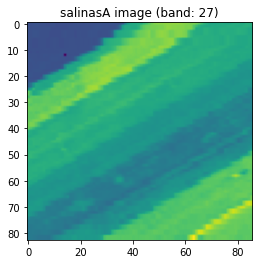

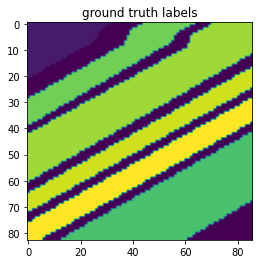

In [19]:
## Import the hyperspectral dataset
urllib.request.urlretrieve('http://www.ehu.eus/ccwintco/uploads/d/df/SalinasA.mat', 'salinasA.mat')
data = scipy.io.loadmat('salinasA.mat')
image = data['salinasA']
print("image shape:",image.shape)

## Display a random sample band of the image
rand_slice = np.random.randint(image.shape[2])
plt.title('salinasA image (band: %d)'%rand_slice)
plt.imshow(image[:,:,rand_slice])
plt.show()

## Import the ground truth labels
urllib.request.urlretrieve('http://www.ehu.eus/ccwintco/uploads/a/aa/SalinasA_gt.mat', 'salinasA_gt.mat')
data = scipy.io.loadmat('salinasA_gt.mat')
gt = data['salinasA_gt']
labels = gt.flatten().astype(int)
map = np.arange(15)
map[10:15] = np.arange(2,7)
labels = map[labels]
plt.title('ground truth labels')
plt.imshow(gt)
plt.show()

Random Sampling
0.490333% training data
Number of Labels,Accuracy
Laplace: 35,78.488
0.0 0.00014078558355624384
Number of Labels,Accuracy
Laplace: 36,78.541
0.0 0.000140805406927626
Number of Labels,Accuracy
Laplace: 37,79.609
0.0 0.0001408252358822701
Number of Labels,Accuracy
Laplace: 38,79.592
0.0 0.00014084507042253522
Number of Labels,Accuracy
Laplace: 39,79.138
0.0 0.0001408649105507818
Number of Labels,Accuracy
Laplace: 40,79.121
0.0 0.00014088475626937165
Number of Labels,Accuracy
Laplace: 41,78.949
0.0 0.0001409046075806679
Number of Labels,Accuracy
Laplace: 42,78.805
0.0 0.00014092446448703494
Number of Labels,Accuracy
Laplace: 43,78.746
0.0 0.00014094432699083862
Number of Labels,Accuracy
Laplace: 44,78.672
0.0 0.000140964195094446
Number of Labels,Accuracy
Laplace: 45,78.585
0.0 0.00014098406880022558
Number of Labels,Accuracy
Laplace: 46,78.497
0.0 0.0001410039481105471
Number of Labels,Accuracy
Laplace: 47,78.466
0.0 0.0001410238330277817
Number of Labels,Accuracy
Laplace

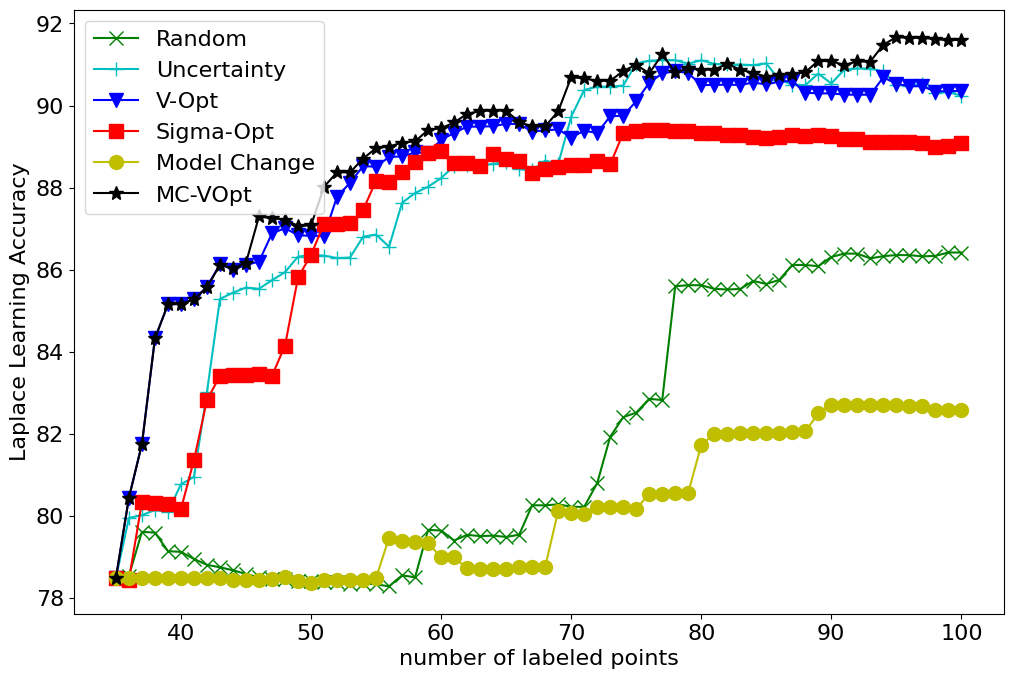

rand: 86.419 unc: 91.106 vopt: 90.836 sopt: 89.394 mc: 82.704 mc-vopt: 91.665


(array([ 35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,
         48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,
         61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,
         74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,
         87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99,
        100]),
 array([78.48796283, 78.54125598, 79.60850584, 79.5915493 , 79.13790675,
        79.12087912, 78.94885163, 78.80496054, 78.74559549, 78.67211728,
        78.58451995, 78.49689791, 78.4656607 , 78.46262341, 78.40315983,
        78.40011287, 78.39706505, 78.39401637, 78.34862385, 78.35968379,
        78.32839192, 78.28297091, 78.54822765, 78.50282486, 79.65814381,
        79.64114157, 79.39805002, 79.53646128, 79.50530035, 79.51653944,
        79.48536689, 79.53902715, 80.25738934, 80.25459689, 80.28009619,
        80.22071307, 80.21791425, 80.79535805, 81.92498231, 82.40373726,
        82.51451225, 82.85188332, 82

In [55]:
#1. Non-local means
F = non_local_means(image, 2)
W = weight_matrix(F)
active_learning_simulation(W, labels, 5, 100, 'Laplace', 'sequential')

feature vector shape:  (7138, 5600)
Total Variation (41 components):  0.9988904434062367
pca image shape:  (83, 86, 41)
kNN search with Annoy approximate nearest neighbor package...
Progress: |██████████████████████████████████████████████████| 100.0% Complete
k=2 connected=False
k=3 connected=False
k=4 connected=False
k=5 connected=True
k=10 connected=True
weight matrix shape:  (7138, 7138)
Random Sampling
0.490333% training data
Number of Labels,Accuracy
Laplace: 35,77.446
0.0 0.00014078558355624384
Number of Labels,Accuracy
Laplace: 36,77.894
0.0 0.000140805406927626
Number of Labels,Accuracy
Laplace: 37,77.933
0.0 0.0001408252358822701
Number of Labels,Accuracy
Laplace: 38,77.958
0.0 0.00014084507042253522
Number of Labels,Accuracy
Laplace: 39,77.926
0.0 0.0001408649105507818
Number of Labels,Accuracy
Laplace: 40,77.839
0.0 0.00014088475626937165
Number of Labels,Accuracy
Laplace: 41,77.808
0.0 0.0001409046075806679
Number of Labels,Accuracy
Laplace: 42,78.777
0.0 0.000140924464487

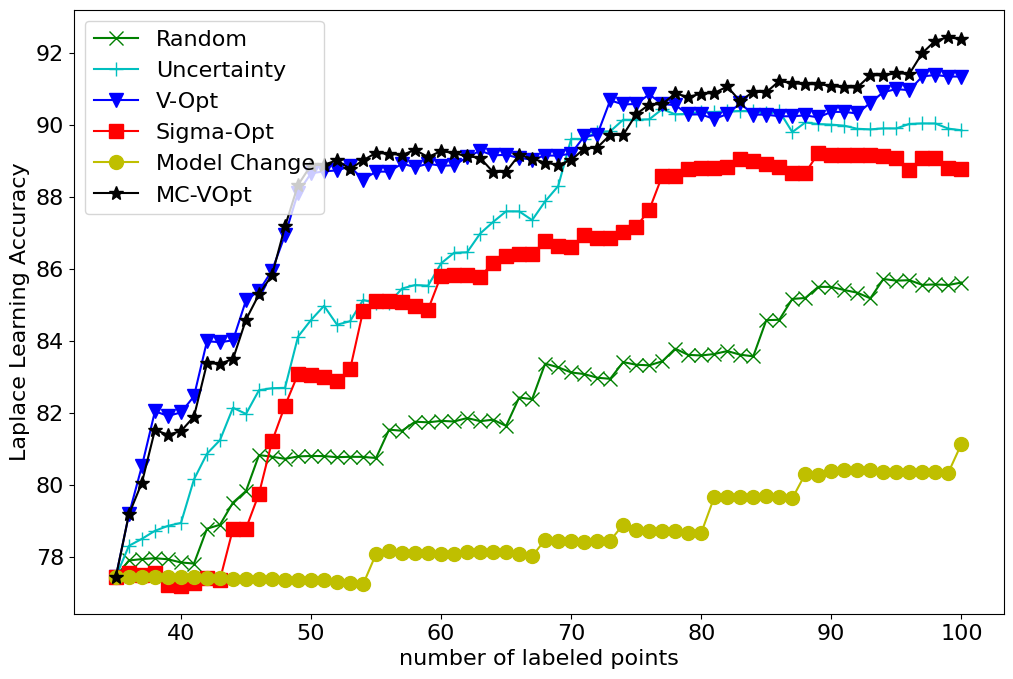

rand: 85.718 unc: 90.440 vopt: 91.392 sopt: 89.218 mc: 81.131 mc-vopt: 92.442


(array([ 35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,
         48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,
         61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,
         74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,
         87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99,
        100]),
 array([77.44614951, 77.89355111, 77.93268554, 77.95774648, 77.92646852,
        77.83882784, 77.80752431, 78.77677565, 78.88653982, 79.50380603,
        79.82517975, 80.82346306, 80.77845156, 80.71932299, 80.787135  ,
        80.79853273, 80.79582334, 80.76488851, 80.77628793, 80.77357425,
        80.74262318, 81.53064106, 81.49978817, 81.75141243, 81.73470829,
        81.77451257, 81.75780698, 81.85415489, 81.76678445, 81.80661578,
        81.63438428, 82.42364253, 82.37873002, 83.36633663, 83.26495968,
        83.12110922, 83.07626999, 82.97480894, 82.94409059, 83.40883352,
        83.33569305, 83.31917304, 83

In [56]:
#2. Nonlocalmeans-PCA
feat_vec = non_local_means(image, 2)
feat_vec = feat_vec.reshape(image.shape[0], image.shape[1], feat_vec.shape[1])
pca_image = PCA(feat_vec)
W = weight_matrix(pca_image.reshape(image.shape[0]*image.shape[1], pca_image.shape[2]))
active_learning_simulation(W, labels, 5, 100, 'Laplace', 'sequential')

Total Variation (9 components):  0.9996000503220223
pca image shape:  (83, 86, 9)
feature vector shape:  (7138, 225)
kNN search with Annoy approximate nearest neighbor package...
Progress: |██████████████████████████████████████████████████| 100.0% Complete
k=2 connected=False
k=3 connected=False
k=4 connected=False
k=5 connected=True
k=10 connected=True
weight matrix shape:  (7138, 7138)
Random Sampling
0.490333% training data
Number of Labels,Accuracy
Laplace: 35,77.404
0.0 0.00014078558355624384
Number of Labels,Accuracy
Laplace: 36,77.499
0.0 0.000140805406927626
Number of Labels,Accuracy
Laplace: 37,77.369
0.0 0.0001408252358822701
Number of Labels,Accuracy
Laplace: 38,77.366
0.0 0.00014084507042253522
Number of Labels,Accuracy
Laplace: 39,77.419
0.0 0.0001408649105507818
Number of Labels,Accuracy
Laplace: 40,77.430
0.0 0.00014088475626937165
Number of Labels,Accuracy
Laplace: 41,77.455
0.0 0.0001409046075806679
Number of Labels,Accuracy
Laplace: 42,77.424
0.0 0.000140924464487034

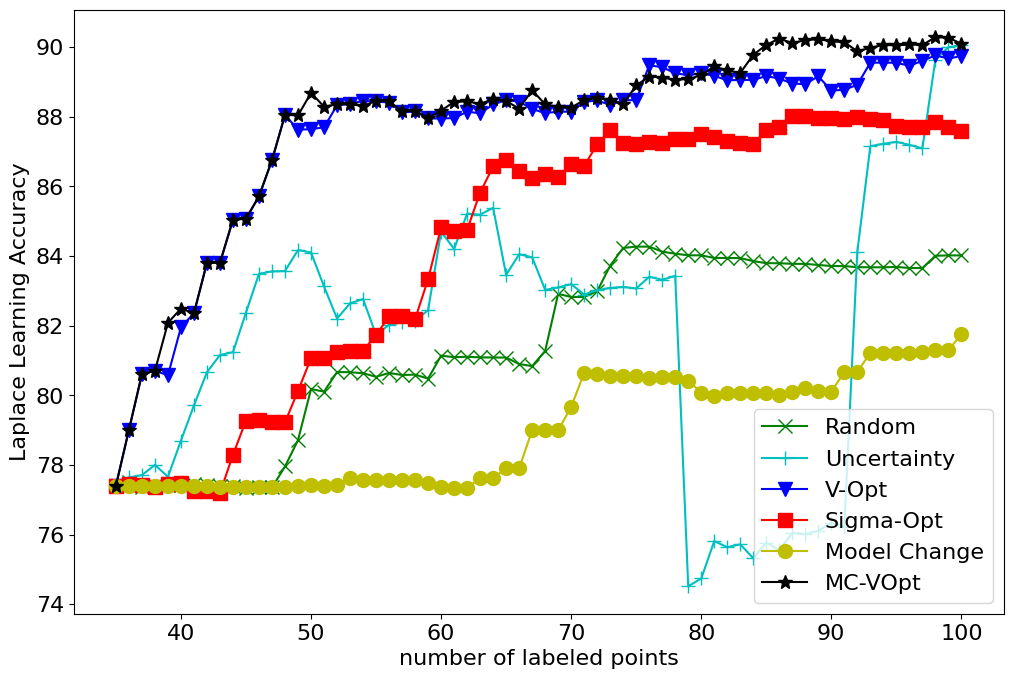

rand: 84.270 unc: 90.054 vopt: 89.759 sopt: 88.030 mc: 81.756 mc-vopt: 90.284


(array([ 35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,
         48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,
         61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,
         74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,
         87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99,
        100]),
 array([77.40391384, 77.49929597, 77.36938459, 77.36619718, 77.41935484,
        77.43026205, 77.45526279, 77.42390079, 77.40662438, 77.38934311,
        77.32976174, 77.35476593, 77.35157242, 77.95486601, 78.71349979,
        80.17776524, 80.10441654, 80.66610217, 80.66337332, 80.63241107,
        80.53084851, 80.64106185, 80.58183872, 80.59322034, 80.47746857,
        81.13873976, 81.09368376, 81.10514415, 81.08833922, 81.08566582,
        81.08299166, 80.89649321, 80.83722246, 81.27298444, 82.91130287,
        82.82399547, 82.82156502, 82.98896122, 83.72257608, 84.22989807,
        84.27014017, 84.26791277, 84

In [57]:
#3. PCA-Nonlocalmeans
pca_image = PCA(image)
F = non_local_means(pca_image, 2)
W = weight_matrix(F)
active_learning_simulation(W, labels, 5, 100, 'Laplace', 'sequential')

kNN search with Annoy approximate nearest neighbor package...
Progress: |██████████████████████████████████████████████████| 100.0% Complete
k=2 connected=False
k=3 connected=False
k=4 connected=False
k=5 connected=True
k=10 connected=True
weight matrix shape:  (7138, 7138)
Random Sampling
0.490333% training data
Number of Labels,Accuracy
Laplace: 35,64.930
0.0 0.00014078558355624384
Number of Labels,Accuracy
Laplace: 36,64.869
0.0 0.000140805406927626
Number of Labels,Accuracy
Laplace: 37,66.822
0.0 0.0001408252358822701
Number of Labels,Accuracy
Laplace: 38,66.789
0.0 0.00014084507042253522
Number of Labels,Accuracy
Laplace: 39,66.685
0.0 0.0001408649105507818
Number of Labels,Accuracy
Laplace: 40,66.484
0.0 0.00014088475626937165
Number of Labels,Accuracy
Laplace: 41,66.366
0.0 0.0001409046075806679
Number of Labels,Accuracy
Laplace: 42,67.714
0.0 0.00014092446448703494
Number of Labels,Accuracy
Laplace: 43,67.639
0.0 0.00014094432699083862
Number of Labels,Accuracy
Laplace: 44,67.5

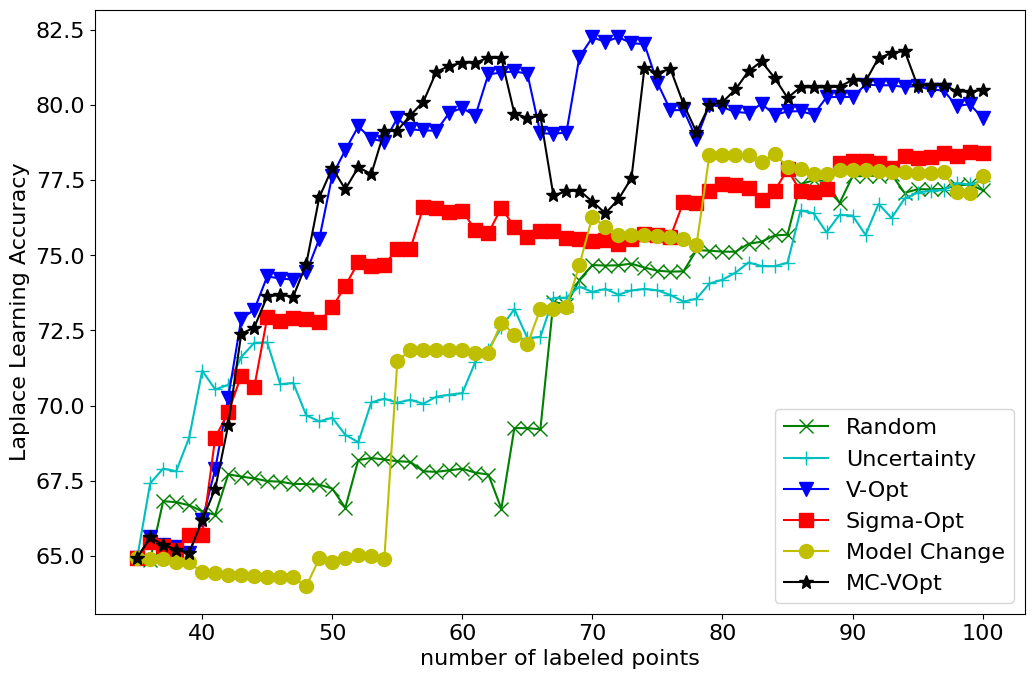

rand: 77.686 unc: 77.479 vopt: 82.253 sopt: 78.420 mc: 78.367 mc-vopt: 81.800


(array([ 35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,
         48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,
         61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,
         74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,
         87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99,
        100]),
 array([64.93031114, 64.86905097, 66.82157443, 66.78873239, 66.68544865,
        66.48351648, 66.36607017, 67.71420519, 67.63918252, 67.57823513,
        67.48907373, 67.47038917, 67.3952898 , 67.39069111, 67.37198477,
        67.24040632, 66.6008184 , 68.19079876, 68.25688073, 68.21005082,
        68.14908937, 68.13047162, 67.81528033, 67.79661017, 67.84856618,
        67.90053687, 67.7688286 , 67.70774449, 66.57243816, 69.25360475,
        69.24925774, 69.21662896, 73.45495687, 73.35219236, 74.18305277,
        74.6745897 , 74.65685581, 74.66742145, 74.72045294, 74.58946772,
        74.486762  , 74.45482866, 74

In [61]:
#4. PCA-NLM-VAE
M = np.load('SalinasA_pca_nlm_vae.npz')
data = M['data']
W = weight_matrix(data)
active_learning_simulation(W, labels, 5, 100, 'Laplace', 'sequential')